# Filtering test
This notebook can be run to test the clearsky filtering implemented in `filtering.py`.

## Get irradiance data from NREL

To download irradiance data from NREL's Solar Radiation Research Laboratory:
1. Visit https://www.nrel.gov/midc/srrl_bms
2. Choose the start and end dates to get ~ 1 month of data
3. Check the irradiance parameter `Global 40-South CMP11`: this is the irradiance on a south-facing panel tilted 40 degrees
4. Check the first output parameter, `Selected 1-Min Data (ASCII Text)`
5. Download the data to `rdtools\docs` by clicking `Submit`

In [6]:
data_loc = '20150823.csv'
import pandas as pd
data = pd.read_csv(data_loc)
data['time'] = data.iloc[:,0] + ' ' + data.iloc[:,1]
data = data.set_index(pd.to_datetime(data['time']))
data.index = data.index.tz_localize('Etc/GMT+7')
data = data[~data.index.duplicated(keep='first')]
data = data.reindex(index=pd.date_range(start=data.index[0],end=data.index[-1],freq='1T')).fillna(0) # Since nighttime times might not be included
irrad_long = data['Global 40-South CMP11 [W/m^2]']
print(irrad_long.head())

2015-08-23 05:23:00-07:00    1.82817
2015-08-23 05:24:00-07:00    1.91263
2015-08-23 05:25:00-07:00    2.19580
2015-08-23 05:26:00-07:00    3.00556
2015-08-23 05:27:00-07:00    3.74577
Freq: T, Name: Global 40-South CMP11 [W/m^2], dtype: float64


## Down-sample the data to some desired frequency
The data from NREL is minutely; to test at slower frequencies, first down-sample the data. Here we will downsample to 30-minute, left-labelled bins. The left-labelling is important: when getting the clearsky irradiance values with `remove_cloudy_times`, the times will be shifted by half a period length (since we set `correct_bin_labelling=True` when calling the function). This way, the clearsky irradiance values returned correspond to the middle of the bin period.

In [7]:
freq = 30 # minutes
irrad = irrad_long.resample(str(freq)+'T',label='left').mean()
data_filtered = data.resample(str(freq)+'T',label='left').mean()
print(irrad.head())

2015-08-23 05:00:00-07:00      3.199307
2015-08-23 05:30:00-07:00     20.811410
2015-08-23 06:00:00-07:00     65.845247
2015-08-23 06:30:00-07:00    142.603107
2015-08-23 07:00:00-07:00    275.439200
Freq: 30T, Name: Global 40-South CMP11 [W/m^2], dtype: float64


## Specify the properties of the PV system and perform the clearsky filtering
This includes the coordinates and elevation of the system as well as its tilt and azimuth angles. Use these parameters to model the system in `PVLib`.

In [8]:
# properties of the PV system at NREL's South Table Mountain site
latlon = [39.742,-105.18]
tilt = 40
azimuth = 180
elevation = 1828.8

import pvlib

# model the solar panel with PVLib
system_noloc = pvlib.pvsystem.PVSystem(surface_tilt=tilt,surface_azimuth=azimuth)
loc = pvlib.location.Location(latlon[0],latlon[1],altitude=elevation)
system_loc = pvlib.pvsystem.LocalizedPVSystem(pvsystem=system_noloc,location=loc)

Then, call `remove_cloudy_times`, which will filter out rows from the dataframe `data` when the series `irrad` is determined to be cloudy. Finally, based on which times are determined to be clear (stored in `is_clear`), filter out entire cloudy days from `irrad` with `remove_cloudy_days`. Days determined to be cloudy are those in which less than `thresh` portion of the points between `start_time` and `end_time` are clear.

`remove_clear_times` will call a function `detect_clearsky_params`, which selects the input parameters to `detect_clearsky` based on the period of the data `w` (in minutes). Those parameters are:
- `dur = max(15,w*3)`, the duration of the moving window in which `detect_clearsky` performs its calculations;
- `mean_diff = max(75,w/2.0)`, the maximum allowable mean difference between the observed and clearsky irradiances during the moving window;
- `max_diff = max(120,w/1.5)`, the maximum allowable maximum difference between the observed and clearsky irradiances during the moving window;
- `lower_line_length = min(-25,-1.0*w/2.0)`, the lower limit for the difference in line length (when plotting irradiance vs time) between the observed and clearsky irradiances;
- `upper_line_length = max(30,w/2.0)`, the upper limit for the difference in line length (when plotting irradiance vs time) between the observed and clearsky irradiances.

There are other parameters that are not a function of the data period `w`:
- `var_diff`, the maximum variance between the two time series;
- `slope_dev`, the maximum allowable difference in slope between the two time series.
Both these parameters are set to very high values, such that they won't cause any points to be considered cloudy.

These parameters were arrived at via trial-and-error and haven't been tested over a range of data periods.

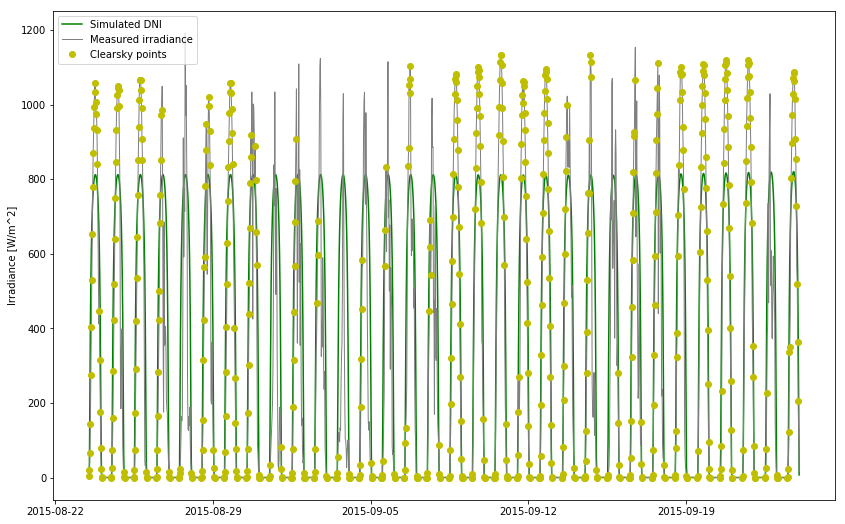

In [9]:
import os, sys
lib_path = os.path.abspath(os.path.join('..', 'rdtools'))
sys.path.append(lib_path)
import filtering

# Remove the cloudy times with filtering.py
df_filtered, is_clear = filtering.remove_cloudy_times(data_filtered,irrad,system_loc,viz=True,correct_bin_labelling=True,return_when_clear=True)    

# Based on these cloudy times, remove the cloudy days
just_clear_days = filtering.remove_cloudy_days(irrad,is_clear,start_time='8:00',end_time='16:00',thresh=0.8)

Plot the original irradiance and irradiance from days selected as clearsky days with `remove_cloudy_days`.

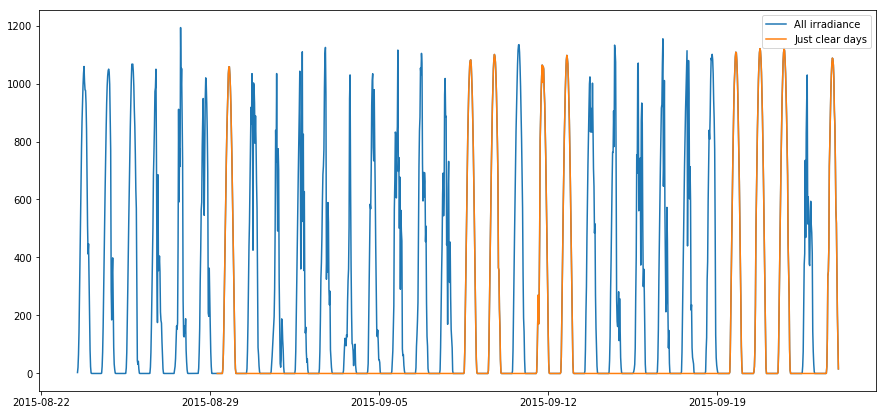

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,7))
ax=fig.add_subplot(111)
ax.plot(irrad,label='All irradiance')
ax.plot(just_clear_days,label='Just clear days')
ax.legend()
plt.show()